# Having fun with py-starbound

## Imports:

In [2]:
import configparser

import glob
import starbound as sb
import mmap

import json

import utils

import pandas as pd
import seaborn as sns

## Setting the file source

In [3]:
config: configparser.ConfigParser = configparser.ConfigParser()
config.read("config.ini")

starbound_src_folder: str = config.get('src', 'folder')
player_folder: str = f"{starbound_src_folder}/storage/player"
universe_folder: str = f"{starbound_src_folder}/storage/universe"

## Working with character files:

We first load the characters into an *global* array to not need to redo the file operations every time.

In [17]:
players: list[sb.VersionedJSON] = []
player_files = list(glob.iglob(f"{player_folder}/*.player", recursive=True))

for file in player_files:
	with open(file, 'r+b') as fh:
		player: sb.VersionedJSON = sb.read_sbvj01(fh)
		players.append(player)

### Now a very simple operation to print a specific string to get the characters:

In [18]:
for player in players:
	name: str = player.data['identity']['name']
	gender: str = player.data['identity']['gender']
	species: str = player.data['identity']['species']
	print(f'You got a {gender} {species.title()} with the name: "{name}"')

You got a female Novakid with the name: "Jane"
You got a female Apex with the name: "Myranda"
You got a female Hylotl with the name: "Shrine Maiden"
You got a female Human with the name: "Lilly"
You got a male Hylotl with the name: "Noboru"
You got a female Floran with the name: "Ru"
You got a male Glitch with the name: "Stormlord"
You got a male Avian with the name: "Nihuatl"


### Dumping the JSON Data into a json file:

In [8]:
for player in players:
	name: str = player.data['identity']['name']
	with open(f'{name}.json', 'w', encoding='utf-8') as f:
		json.dump(player.data, f, ensure_ascii=False, indent=4)

## Working with world files:

We first load the worlds into an *global* array to not need to redo the file operations every time.

In [4]:

worlds: list[sb.World] = []

world_files = list(glob.iglob(f"{universe_folder}/*_*_*.world", recursive=True))
for file in world_files:
	with open(file, 'r+b') as fh:
		mm: mmap = mmap.mmap(fh.fileno(), 0, access=mmap.ACCESS_READ)
		world: sb.World = sb.World(mm)
		# world.read_metadata()
		worlds.append(world)

### Printing all the important world details

In [6]:
for world in worlds:
	print(f'World Name: {utils.strip_colors(world.info.name)}')
	print(f'World size: {world.width}×{world.height}')
	print(f'World Description: {world.info.description}')
	print(f'--------------------------------------------------------------------------------')
	# x, y = world.metadata['playerStart']
	# print(f'Player spawns at ({x}, {y})')
	# Some funny stuff with getting entities...
	# try:
	# 	rx, ry = x // 32, y // 32
	# 	# print(f'Spawn Region is: ({rx}, {ry})')
	# 	entities = world.get_entities(int(rx), int(ry))
	# 	for entity in entities:
	# 		if entity.name == 'ObjectEntity':
	# 			items = entity.data.get("items")
	# 			for item in items:
	# 				if item == None:
	# 					break
	# 				print(item)
	# # Just ignoring all Exceptions...
	# except Exception:
	# 	pass

World: Sadr Delta IV
World size: 6000×3000
World Description: Tier 2 Planet
--------------------------------------------------------------------------------
World: Acubens Tide I
World size: 3000×2000
World Description: Tier 1 Planet
--------------------------------------------------------------------------------
World: Castor Traverse V
World size: 4000×3000
World Description: Tier 2 Planet
--------------------------------------------------------------------------------
World: Castor Traverse I
World size: 4000×3000
World Description: Tier 2 Planet
--------------------------------------------------------------------------------
World: Castor Traverse II
World size: 4000×3000
World Description: Tier 2 Planet
--------------------------------------------------------------------------------
World: Castor Traverse III
World size: 3000×2000
World Description: Tier 1 Planet
--------------------------------------------------------------------------------
World: Castor Traverse III - a
World s

### Getting the Amount of dungeons

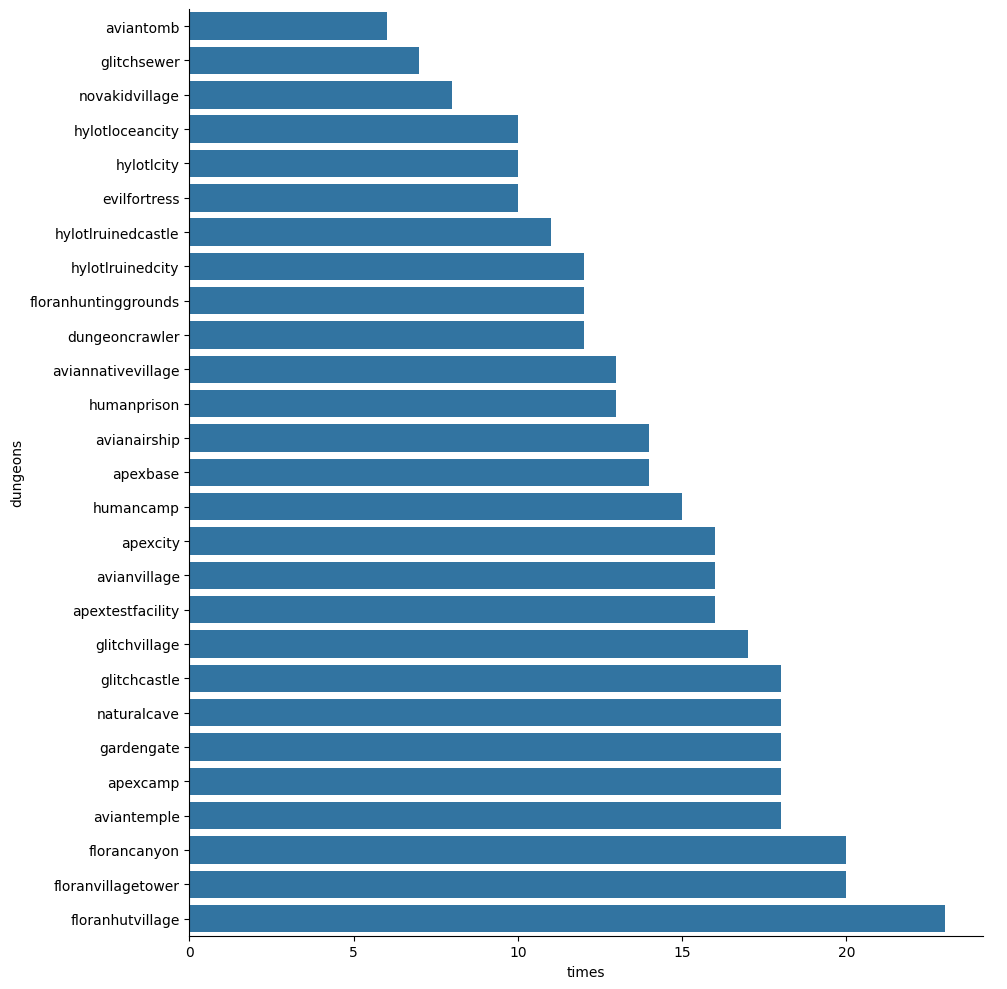

In [12]:
known_dungeons: dict[str, int] = {}

for world in worlds:
	dungeons: list[str] = world.info.dungeons
	for dungeon in dungeons:
		if dungeon in known_dungeons:
			known_dungeons[dungeon] = known_dungeons[dungeon] + 1
		else:
			known_dungeons[dungeon] = 1

dungeons = pd.Series(data=known_dungeons).explode().reset_index(name="times").rename(columns={"index": "dungeons"}).sort_values("times")

sns.catplot(
	data=dungeons,
	kind="bar",
	x="times",
	y="dungeons",
	height=10
)

### Getting the amount of biomes

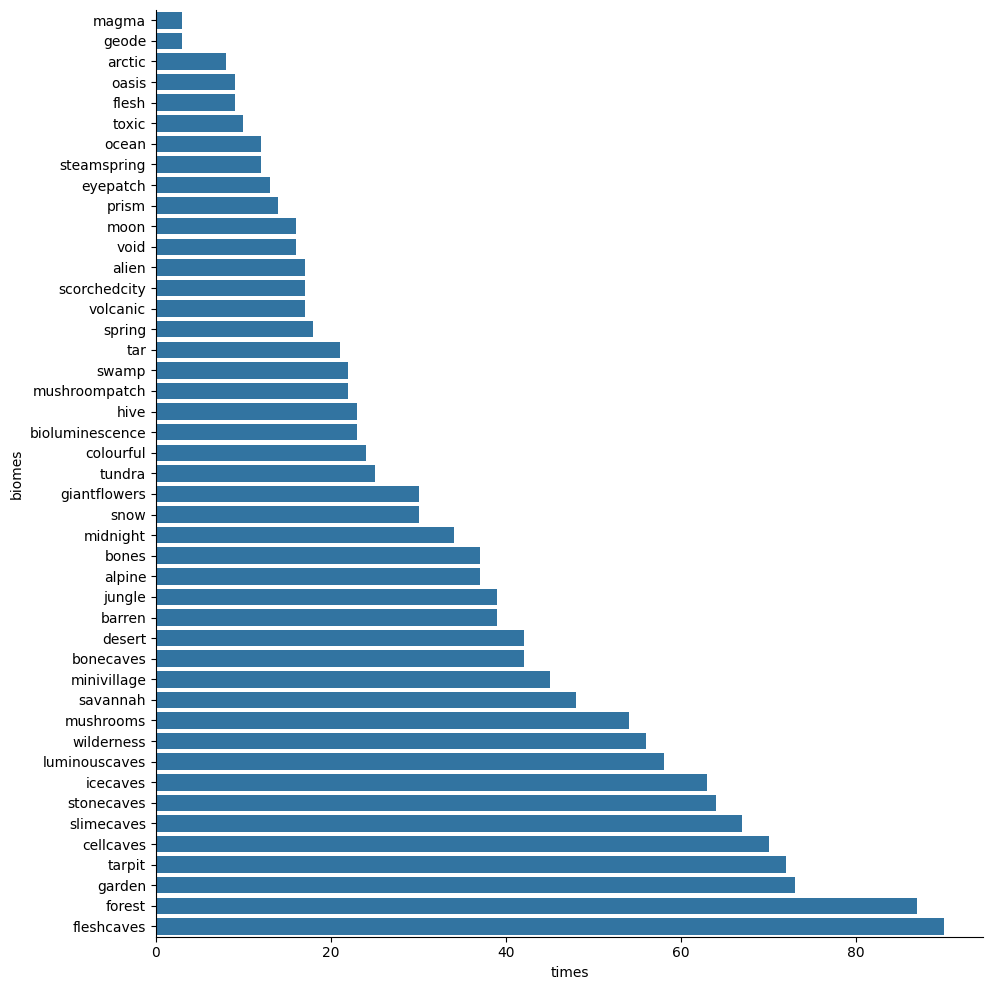

In [11]:

known_biomes: dict[str, int]  = {}

for world in worlds:
	biomes: list[str] = world.info.biomes
	for biome in biomes:
		if "underground" in biome or "asteroids" in biome or "atmosphere" in biome or "core" in biome or "oceanfloor" in biome or "rust" in biome:
			continue
		if biome in known_biomes:
			known_biomes[biome] = known_biomes[biome] + 1
		else:
			known_biomes[biome] = 1

biomes = pd.Series(data=known_biomes).explode().reset_index(name="times").rename(columns={"index": "biomes"}).sort_values("times")

sns.catplot(
	data=biomes,
	kind="bar",
	x="times",
	y="biomes",
	height=10
)